In [31]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas
import cmocean
from copy import copy


df = pandas.read_csv('../data/Gaia-SDSS.csv')
df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df_S.group_id.unique()

df_GC = pandas.read_csv('../data/Sequoia_GCs.csv')
GCnames = df_GC.ID.unique()
nGCs = size(GCnames)

In [2]:
# Density points for full sample
x1,y1,dens1 = PointScatter((df.Jphi).values,(df.JR).values)

In [57]:
# Fit data to three component halo
means_init = zeros(shape=(3,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-2.0]) # Halo
means_init[2,:] = array([0.0,126.0,0.0,-1.8]) # Halo
weights_init = array([0.5,0.34,0.16])
covariance_type = 'full'
data = array([df.GalRVel,df.GalphiVel,df.GalzVel,df.feh]).T
clf = mixture.GaussianMixture(n_components=3, covariance_type=covariance_type,
                              weights_init=weights_init,means_init=means_init,tol=1e-12,reg_covar=1e-8,max_iter=1000)
clf.fit(data)
Ps = clf.predict_proba(data)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
eta = ws[0]

Ps = clf.predict_proba(data)
imod = argmax(Ps,axis=1)
df1 = df.loc[imod==0]
df2 = df.loc[imod==1]
df3 = df.loc[imod==2]

In [10]:
#Get actions for shards
JR_S = []
Jphi_S = []
Jz_S = []
E_S = []
for i in range(0,size(names)):
    namei = names[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand_matched = df.loc[around(df.ra,8).isin(Cand.ra)]
    JR_S = append(JR_S,(Cand_matched.JR).values)
    Jphi_S = append(Jphi_S,(Cand_matched.Jphi).values)
    Jz_S = append(Jphi_S,(Cand_matched.Jz).values)
    E = append(E_S,(Cand_matched.E).values)

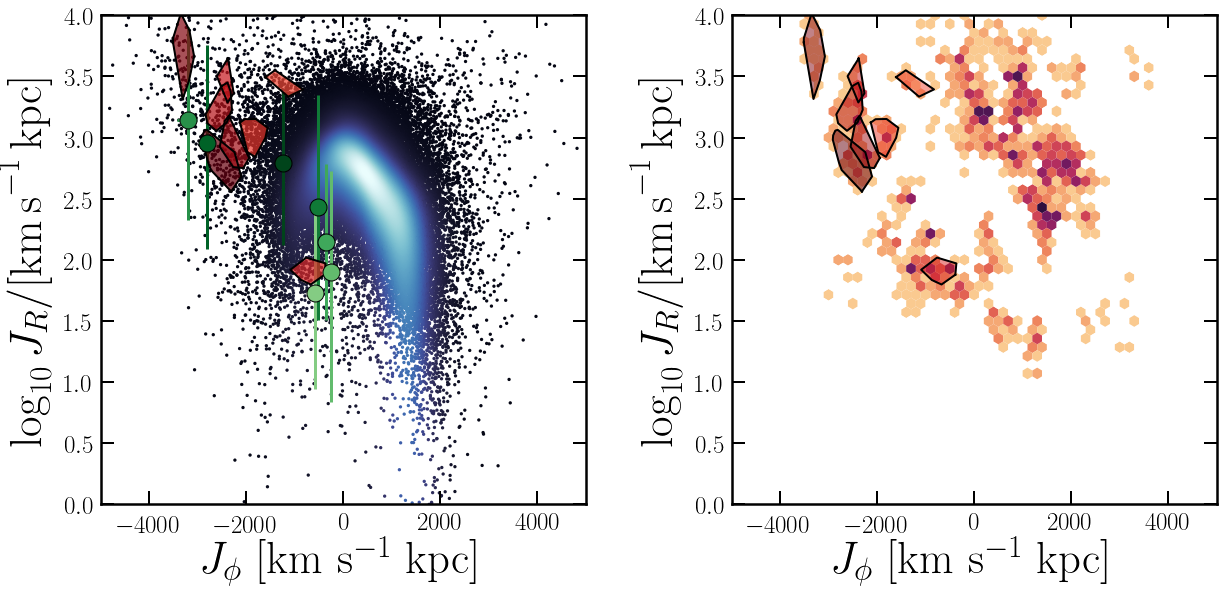

In [55]:
rlab = r'$\log_{10}{J_R/{\rm [km\,s}^{-1}\,{\rm kpc}]}$'
plab = '$J_\phi$ [km s$^{-1}$ kpc]'
zlab = '$J_z$ [km s$^{-1}$ kpc]'
Elab = r'$E$ [$10^5$ km$^2$ s$^{-2}$]'


gsize = 50

cmap = cmocean.cm.matter
cmap = copy(plt.get_cmap(cmap))
cmap.set_under('white', 1.0)


jrmin = 1.0
jrmax = 10000.0
jpmin = -4900.0
jpmax = 4900.0
jzmin = 0.0
jzmax = 4900.0

fig,ax1,ax2 = MyDoublePlot(plab,rlab,plab,rlab,wspace=0.3,size_y=9)


xmin = -5000.0
xmax = 5000.0
ymin = 0.0
ymax = 4.0
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
ax2.set_xlim([xmin,xmax])

ax1.scatter(x1, log10(y1), c=dens1, s=11, edgecolor='',cmap=cmocean.cm.ice,label=None,rasterized=True)
ax2.hexbin(Jphi_S,log10(JR_S),extent=(xmin,xmax,ymin,ymax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)




# Plot some shards
Examples = array(['S1','Rg1','Rg2','Rg3','Rg4','Rg5','Rg6','Rg7'])
n_ex = size(Examples)
cols = flipud(cm.Reds(linspace(0,1,n_ex+10)))
for i in range(0,n_ex):
    shards_color = cols[i,:]

    namei = Examples[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand_matched = df.loc[around(df.ra,8).isin(Cand.ra)]
    x = (Cand_matched.Jphi).values
    y = log10((Cand_matched.JR).values)
    #ax1.plot(x,y,'.',color=shards_color,markersize=10)

    points = array([x,y]).T
    hull = ConvexHull(points)
    x_edge = points[hull.vertices,0]
    y_edge = points[hull.vertices,1]
    ax1.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.7,color=shards_color,zorder=2)
    ax1.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color='k',lw=2,zorder=2)

    ax2.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.5,color=shards_color,zorder=2)
    ax2.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color='k',lw=2,zorder=2)

    
cols = flipud(cm.Greens(linspace(0,1,nGCs+5)))   
mrk = 'o'
s = 17
for i in range(0,nGCs):
    GC_color = cols[i,:]
    namei = GCnames[i]
    Cand = df_GC.loc[df_GC['ID'] == namei]
    x = Cand.Jphi.values
    y = log10(Cand.JR.values)
    xerr = array([[Cand.Jphi_el.values],[Cand.Jphi_eu.values]])
    yerr = array([[y],[y]])-log10(array([[Cand.JR_el.values+y],[Cand.JR_eu.values+y]]))

    ax1.errorbar(x, y, yerr=yerr, xerr=xerr,markersize=s,color=GC_color,
                     marker=mrk,linewidth=3,markeredgecolor='k')    
# Save
pltname = 'vRvphi_subs'
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  

In [97]:
# Density points for full sample
J1tot = ((df1.JR).values+abs(df1.Jphi).values+(df1.Jz).values)
J2tot = ((df2.JR).values+abs(df2.Jphi).values+(df2.Jz).values)
J3tot = ((df3.JR).values+abs(df3.Jphi).values+(df3.Jz).values)

x1,y1,dens1 = PointScatter((df1.Jphi).values,(df1.E).values)
x2,y2,dens2 = PointScatter((df2.Jphi).values,(df2.E).values)
x3,y3,dens3 = PointScatter((df3.Jphi).values,(df3.E).values)

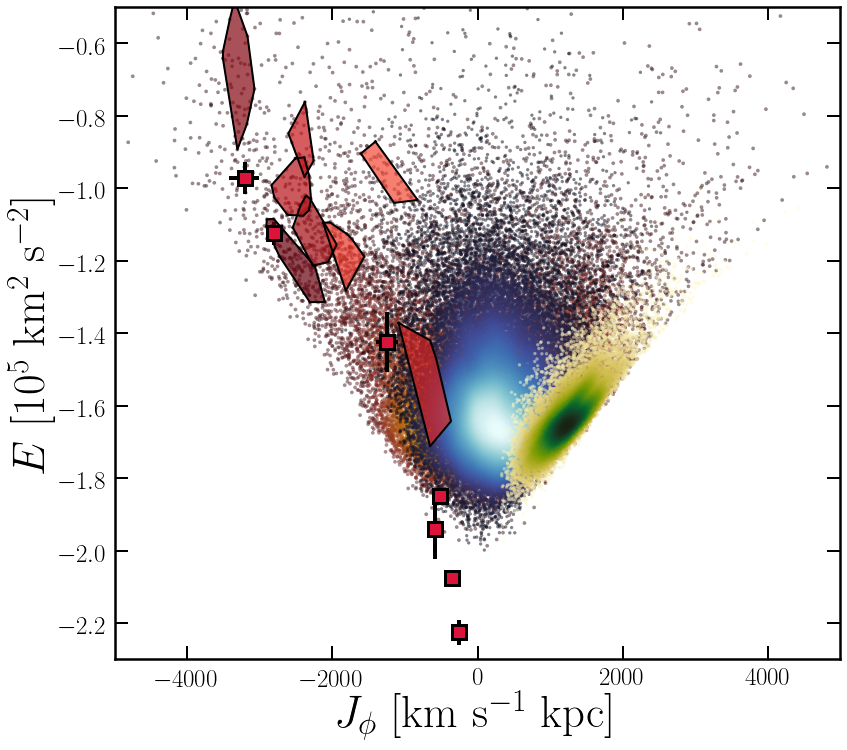

In [132]:
fig,ax1 = MySquarePlot(plab,Elab)
xmin = -5000.0
xmax = 5000.0
ymin = -2.3
ymax = -0.5
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])

ax1.scatter(x2, y2/1.0e5, c=(dens2), s=14, edgecolor='',cmap=cmocean.cm.solar,label=None,rasterized=True,alpha=0.5)
ax1.scatter(x1, y1/1.0e5, c=(dens1), s=11, edgecolor='',cmap=cmocean.cm.ice,label=None,rasterized=True,alpha=0.5)
ax1.scatter(x3, y3/1.0e5, c=(dens3), s=11, edgecolor='',cmap=cmocean.cm.speed,label=None,rasterized=True,alpha=0.5)

#ax1.scatter(x2,y2/1.0e5,c='orange',s=11,edgecolor='',rasterized=True)
#ax1.scatter(x1,y1/1.0e5,c='blue',s=5,edgecolor='',rasterized=True)
#ax1.scatter(x3,y3/1.0e5,c='forestgreen',s=5,edgecolor='',rasterized=True)

# Plot some shards
Examples = array(['S1','Rg1','Rg2','Rg3','Rg4','Rg5','Rg6','Rg7'])
n_ex = size(Examples)
cols = flipud(cm.Reds(linspace(0,1,n_ex+10)))
for i in range(0,n_ex):
    shards_color = cols[i,:]

    namei = Examples[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand_matched = df.loc[around(df.ra,8).isin(Cand.ra)]
    Jitot = ((Cand_matched.JR).values+abs(Cand_matched.Jphi).values+(Cand_matched.Jz).values)
    x = Cand_matched.Jphi.values
    y = Cand_matched.E.values/1.0e5

    points = array([x,y]).T
    hull = ConvexHull(points)
    x_edge = points[hull.vertices,0]
    y_edge = points[hull.vertices,1]
    ax1.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.7,color=shards_color,zorder=2)
    ax1.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color='k',lw=2,zorder=2)

cols = flipud(cm.Greens(linspace(0,1,nGCs+5)))   
mrk = 's'
s = 14
for i in range(0,nGCs):
    GC_color = cols[i,:]
    namei = GCnames[i]
    Cand = df_GC.loc[df_GC['ID'] == namei]
    Jitot = ((Cand_matched.JR).values+(Cand_matched.Jphi).values+(Cand_matched.Jz).values)
    x = Cand.Jphi.values
    y = Cand.E.values/1.0e5
    xerr = array([[Cand.Jphi_el.values],[Cand.Jphi_eu.values]])
    yerr = array([[Cand.E_el.values],[Cand.E_eu.values]])/1.0e5

    ax1.errorbar(x, y, yerr=yerr, xerr=xerr,markersize=s,markerfacecolor='crimson',
                     marker=mrk,linewidth=4,markeredgecolor='k',color='k',markeredgewidth=3)    
# Save
pltname = 'ThreeComp_JphiE'
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  



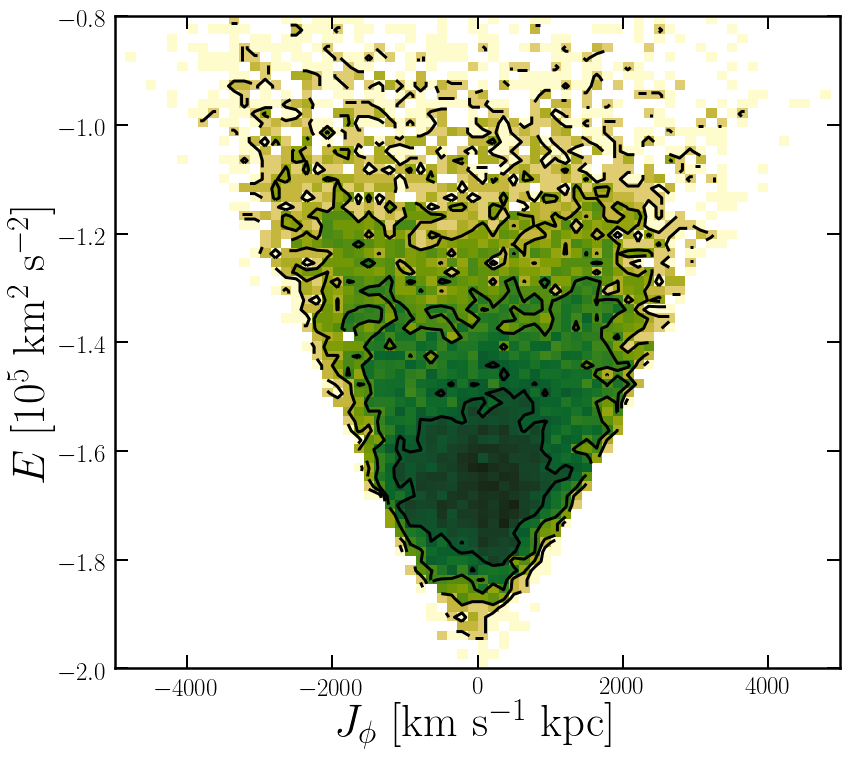

In [162]:
ymax = -0.8
ymin = -2.0
fig,ax1 = MySquarePlot(plab,Elab)
H,xb,yb = histogram2d(df2.Jphi,df2.E/1.0e5,range=((xmin,xmax),(ymin,ymax)),bins=70,normed=True)
xc = (xb[1:]+xb[0:-1])/2
yc = (yb[1:]+yb[0:-1])/2

Hplot = log10(flipud(H.T/amax(H.T)))

ax1.imshow(Hplot,extent=(xmin,xmax,ymin,ymax),aspect='auto',cmap=cmocean.cm.speed)
ax1.contour(xc,yc,flipud(Hplot),5,linewidths=3,colors='k',linestyles='-')

In [163]:
x1,y1,dens1 = PointScatter(log10(df1.JR).values,(df1.E).values)
x2,y2,dens2 = PointScatter(log10(df2.JR).values,(df2.E).values)
x3,y3,dens3 = PointScatter(log10(df3.JR).values,(df3.E).values)

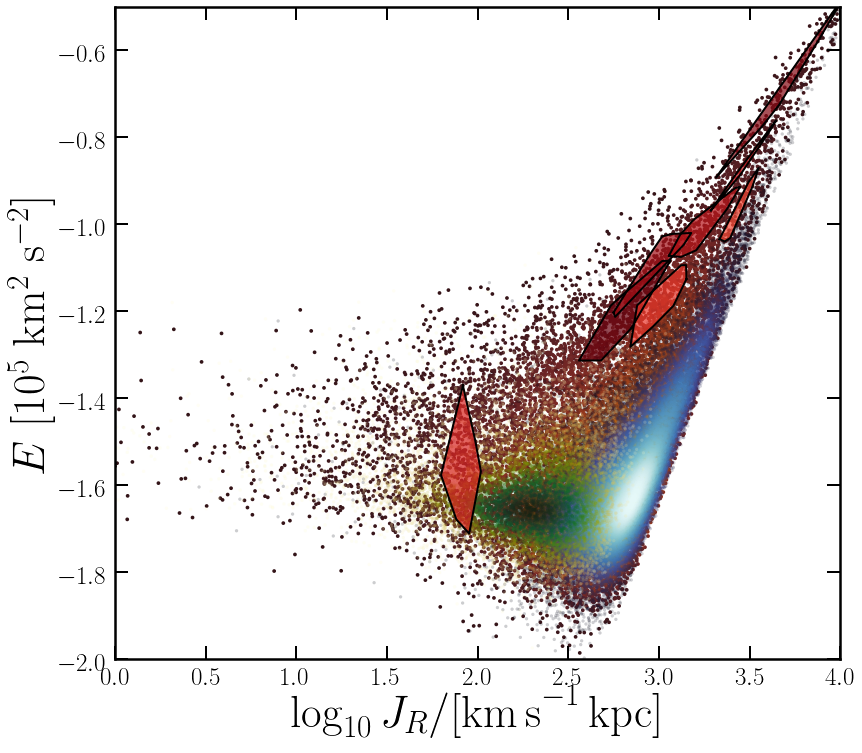

In [169]:
fig,ax1 = MySquarePlot(rlab,Elab)
xmin = 0.0
xmax = 4.0
ymin = -2.0
ymax = -0.5
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])

ax1.scatter(x2, y2/1.0e5, c=(dens2), s=14, edgecolor='',cmap=cmocean.cm.solar,label=None,rasterized=True,alpha=1.0)
ax1.scatter(x1, y1/1.0e5, c=(dens1), s=11, edgecolor='',cmap=cmocean.cm.ice,label=None,rasterized=True,alpha=0.2)
ax1.scatter(x3, y3/1.0e5, c=(dens3), s=11, edgecolor='',cmap=cmocean.cm.speed,label=None,rasterized=True,alpha=0.2)

#ax1.scatter(x2,y2/1.0e5,c='orange',s=11,edgecolor='',rasterized=True)
#ax1.scatter(x1,y1/1.0e5,c='blue',s=5,edgecolor='',rasterized=True)
#ax1.scatter(x3,y3/1.0e5,c='forestgreen',s=5,edgecolor='',rasterized=True)

# Plot some shards
Examples = array(['S1','Rg1','Rg2','Rg3','Rg4','Rg5','Rg6','Rg7'])
n_ex = size(Examples)
cols = flipud(cm.Reds(linspace(0,1,n_ex+10)))
for i in range(0,n_ex):
    shards_color = cols[i,:]

    namei = Examples[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand_matched = df.loc[around(df.ra,8).isin(Cand.ra)]
    x = log10(Cand_matched.JR.values)
    y = Cand_matched.E.values/1.0e5

    points = array([x,y]).T
    hull = ConvexHull(points)
    x_edge = points[hull.vertices,0]
    y_edge = points[hull.vertices,1]
    ax1.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.7,color=shards_color,zorder=2)
    ax1.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color='k',lw=2,zorder=2)

# cols = flipud(cm.Greens(linspace(0,1,nGCs+5)))   
# mrk = 's'
# s = 14
# for i in range(0,nGCs):
#     GC_color = cols[i,:]
#     namei = GCnames[i]
#     Cand = df_GC.loc[df_GC['ID'] == namei]
#     Jitot = ((Cand_matched.JR).values+(Cand_matched.Jphi).values+(Cand_matched.Jz).values)
#     x = Cand.Jphi.values
#     y = Cand.E.values/1.0e5
#     xerr = array([[Cand.Jphi_el.values],[Cand.Jphi_eu.values]])
#     yerr = array([[Cand.E_el.values],[Cand.E_eu.values]])/1.0e5

#     ax1.errorbar(x, y, yerr=yerr, xerr=xerr,markersize=s,markerfacecolor='crimson',
#                      marker=mrk,linewidth=4,markeredgecolor='k',color='k',markeredgewidth=3)    
# Save
pltname = 'ThreeComp_JRE'
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  